In [236]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import precision_score
import os
import gzip
import random
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
#Returns a string of length bytes long
def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [5]:
#Splits the data into num_chunks
def chunk(in_string,num_chunks):
    chunk_size = len(in_string)//num_chunks
    if len(in_string) % num_chunks: chunk_size += 1
    iterator = iter(in_string)
    for _ in range(num_chunks):
        accumulator = list()
        for _ in range(chunk_size):
            try: accumulator.append(next(iterator))
            except StopIteration: break
        yield ''.join(accumulator)

In [132]:
#Returns dataframe of # of files long. Analyze the first length bytes of each file
def trainloader(direclist, filetype, length):
    fileid = np.arange(len(filetype))
    dat = []
    filelabels = []
    c = -1
    for direc in direclist:
        c+=1
        filelabels.append(np.repeat(fileid[c],len(os.listdir(direc))-1))
        for file in os.listdir(direc):
            if file.endswith('.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
    filelabels = np.concatenate(filelabels)
    data = {'Data': dat,
        'Type': filelabels
    }
    df = pd.DataFrame(data, columns = ['Data', 'Type'])
    #print(df.head())
    return(df)

In [163]:
def rowextraction(predicted, truth):
    return(np.where(predicted==truth)[0])

In [209]:
def uncertainty(pred, row_ind, num_classes):
    class_arr = [[] for i in range(num_classes)]
    dist_arr = []
    for ind in row_ind:
        class_ind = np.argmax(pred[ind])
        class_arr[class_ind].append(np.max(pred[ind]))
    for arr in class_arr:
        dist_arr.append([np.mean(arr),np.std(arr)])
    return(dist_arr)

In [7]:
def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [238]:
def confusionmatrix(truth, pred, names):
    cm = confusion_matrix(truth, pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

In [220]:
def classaccuracy(truth, pred, ind, num_classes):
    classes = np.arange(num_classes)
    predcl = np.asarray([np.argmax(pred[i]) for i in ind])
    acc = []
    for cl in classes:
        truth_len = len(np.where(truth == cl)[0])
        pred_len = len(np.where(predcl == cl)[0])
        acc.append(pred_len/truth_len)
    return(acc)

In [234]:
def FileClassifier(Dataset, filetype, ngram_range, max_features, param, num_round, load):
    
    X = Dataset.iloc[:,0]
    y = Dataset.iloc[:,1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    if load == False:
        print("Generating Character Vectorizer...")
        char_vectorizer = TfidfVectorizer(analyzer = 'char',
            ngram_range = ngram_range, max_features = max_features)
        char_vectorizer.fit(X_train)
        train_chars = char_vectorizer.fit_transform(X_train)
        test_chars = char_vectorizer.fit_transform(X_test)
        pickle.dump(char_vectorizer, open("tfidfcv.pkl", "wb"))
        print("Character Vectorizer Saved")
    #train_chars = char_vectorizer.transform(X_train)
    if load == True:
        print("Loading Character Vectorizer...")
        cv1 = pickle.load(open("tfidfcv.pkl", 'rb'))
        print("Character Vectorizer Loaded")
        char_vectorizer = TfidfVectorizer(analyzer = 'char',
            ngram_range = ngram_range, max_features = max_features, vocabulary = cv1.vocabulary)
        train_chars = char_vectorizer.fit_transform(X_train)
        test_chars = char_vectorizer.fit_transform(X_test)

    
    dtrain = xgb.DMatrix(train_chars, label = y_train)
    dtest = xgb.DMatrix(test_chars, label = y_test)
    
    if load == False:
        print("Training Model...")
        model = xgb.train(param, dtrain, num_round)
        pickle.dump(model, open("xgb_class.pkl", "wb"))
        print("Model Saved")
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("xgb_class.pkl", "rb"))
        print("Model Loaded")
    
    FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
    
    preds = model.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    print("Precision: {}".format(precision_score(y_test, best_preds, average='macro')))
    y_test_arr = np.asarray(y_test).reshape(1,-1).squeeze()
    correct_rows = rowextraction(best_preds,y_test_arr)
    class_acc = classaccuracy(y_test_arr, preds, correct_rows, param['num_class'])
    pred_uncertainty = uncertainty(preds, correct_rows, param['num_class'])
    for i in range(param['num_class']):
        print("Class {}".format(filetype[i]) + " mean and sd: {}".format(pred_uncertainty[i])
             + ", Accuracy: {}".format(round(class_acc[i],2)))
    confusionmatrix(y_test_arr, best_preds, filetype)
    
    
    
    return(model)

In [146]:
dirs = ['/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gbff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gff',
       ]
filetype = ['fna', 'gbff', 'gff']

In [150]:
data_iterable = trainloader(dirs, filetype, 1500)

In [153]:
param = {
    'max_depth': 8,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 60 
ngram_range = (3,18)
max_features = 100000
Dataset = data_iterable
load = True

Loading Character Vectorizer...
Character Vectorizer Loaded
Loading Model...
Model Loaded
Precision: 0.8048780487804877
Class fna mean and sd: [0.3423101, 0.0], Accuracy: 1.0
Class gbff mean and sd: [0.33499992, 0.0], Accuracy: 0.08
Class gff mean and sd: [0.99323344, 1.7881393e-07], Accuracy: 0.88


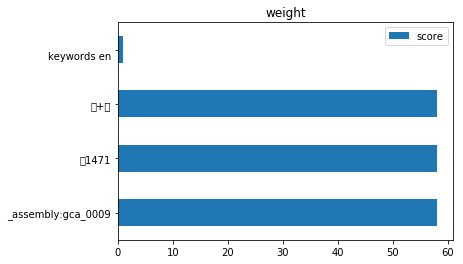

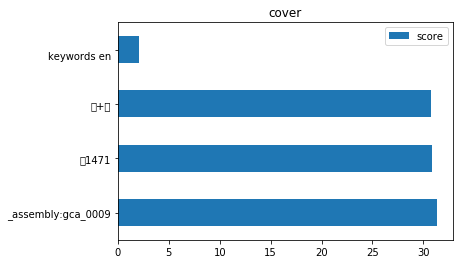

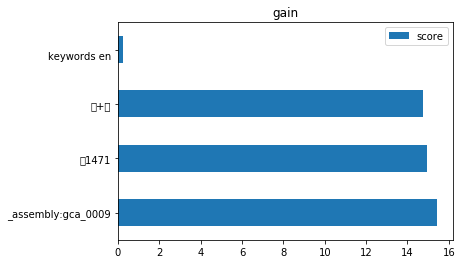

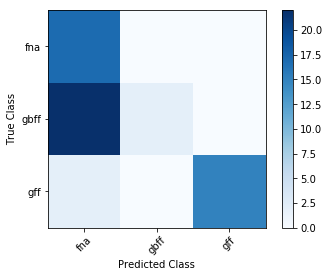

In [239]:
xgbmodel = FileClassifier(Dataset, filetype, ngram_range, max_features, param, num_round, load)